In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
geo_path = 'geo'
df_path = 'df'
raw_path = 'raw'

# zipファイルの取得

追々オリジナルのデータから整形をやり直したくなった時のために保存しておく。

In [3]:
def get_data(n):
    import urllib.request as req
    n = f'{n:02}'
    url = f'https://nlftp.mlit.go.jp/ksj/gml/data/m1kh30/m1kh30-18/1km_mesh_suikei_2018_shape_{n}.zip'
    with open(f'{raw_path}/{n}.zip', 'wb') as f:
        f.write(req.urlopen(url).read())

In [4]:
def get_all():
    for i in range(1, 48):
        get_data(i)

In [5]:
# get_all()

# データ整形

In [6]:
def translate(name):
    import re
    '''
    name : str like PT[0A-C]_\d{4}
    '''
    mapper = {
        "PT0": "総数",
        "PTA": "0～14歳",
        "PTB": "15～64歳",
        "PTC": "65歳以上",
    }
    if re.fullmatch('PT[0A-C]_\d{4}', name):
        parts = name.partition('_')
        return f'{parts[2]}_{mapper[parts[0]]}'
    else:
        return name

def df_preproc(df):    
    
    return (
        df.filter(regex='^PT[0A-C]')# 列を絞る
            .rename(columns=translate)
    )

In [7]:
def preproc(n):
    path = f'{raw_path}/{n:02}.zip'
    gdf = gpd.read_file(path).set_index('MESH_ID')

    # write geojson
    with open(f"{geo_path}/{n:02}.json", "w") as f:
        f.write(gdf.filter(items=["geometry"]).to_json())
    
    # write df for map to json
    df = pd.DataFrame(gdf.drop(labels='geometry', axis=1))
    df_preproc(df).T.to_json(f"{df_path}/{n:02}.json", orient="split")
    
    # 集計のため元のdfを返す
    return df

In [9]:
def main():
    totals = [];
    for i in range(1, 48):
        print(i)
        df = preproc(i)
        totals.append(ex_total(df, i))
        
    pd.concat(totals).to_json('total.json', orient='records')
        

In [10]:
# main()

---

In [312]:
def total_main():
    s = []
    for i in range(1, 48):
#     for i in range(13, 15):
        path = f'{raw_path}/{i:02}.zip'
        sum = pd.DataFrame(gpd.read_file(path)).filter(regex='^PT\d\d?|^PT[A-C]').sum()
        sum.name = f'{i:02}'
        s.append(sum)
        print(i)
        
    total_preproc(pd.DataFrame(s)).to_json('total.json', orient='split')
#     return total_preproc(pd.DataFrame(s))

In [313]:
def total_preproc(df):
    mapper = {
        "000": "総数",
        "00A": "0～14歳",
        "00B": "15～64歳",
        "00C": "65歳以上",
        "101": "0～4歳",
        "102": "5～9歳",
        "103": "10～14歳",
        "104": "15～19歳",
        "105": "20～24歳",
        "106": "25～29歳",
        "107": "30～34歳",
        "108": "35～39歳",
        "109": "40～44歳",
        "110": "45～49歳",
        "111": "50～54歳",
        "112": "55～59歳",
        "113": "60～64歳",
        "114": "65～69歳",
        "115": "70～74歳",
        "116": "75～79歳",
        "117": "80～84歳",
        "118": "85～89歳",
        "119": "90歳以上",
    }
    
    # 全国のデータをまとめた行を追加
    df.loc["00"] = df.sum()
    
    df.sort_index(inplace=True)
    
    # いい感じにpivotする columns -> ["pref", "group", "2020", ...]
    # tidy化
    df.index.name = 'pref'
    df.reset_index(inplace=True)
    df = df.melt(id_vars="pref", var_name='gy')
#     # year列、group列の追加
    append = df['gy'].str.split('_', expand=True)
    append.rename(columns={0: 'group', 1: 'year'}, inplace=True)
    df = pd.concat([df, append], axis=1)
#     # pivot
    df = df.pivot(index=['pref', 'group'], columns='year', values='value')
    
    # groupでソートするために文字幅をそろえる。
    # 総数のあとに大分類(0~14, 15~64, 64~)を並べたいので、小分類は100台にする
    df.reset_index(inplace=True)
    df['group'] = (df.group
                   .str.replace("PT", "")
                   .str.pad(3, fillchar='0')
                   .str.replace(r'\d(\d\d)', r'1\1')
                   .str.replace(r'100', r'000')
                  )

    df.sort_values(by=['pref', 'group'], inplace=True)
    
    # 都道府県名を追加
    # 都道府県コード(1~47)と都道府県名の対応表読み込み
    prefs = pd.read_json('../puboffice.json').T
    # 00を「全国」とする行追加
    prefs.loc[0] = {'name': '全国'}
    prefs["code"] = prefs.index.astype(str).str.pad(2, fillchar='0')
    
    df = df.merge(prefs, left_on='pref', right_on="code", how='left')
    
    # 不要な列削除
    df.drop(columns=['lat', 'lon', 'code'], inplace=True)
    
    df.set_index(["pref", "name", "group"], inplace=True)
    
    # group名を変更
    df.rename(index=mapper, inplace=True)
    
    # クライアントで検索の利便性のためindexを"pref_group"にする
    df.reset_index(inplace=True)
    df['index'] = df.pref + '_' + df.group
    df.set_index('index', inplace=True)
    
    return df

In [314]:
total_main()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


<ipython-input-313-47dabf63c99f>:48: FutureWarning:

The default value of regex will change from True to False in a future version.



---

# sample

## choropleth map

In [11]:
import json
import plotly
import plotly.graph_objects as go
import plotly.express as px

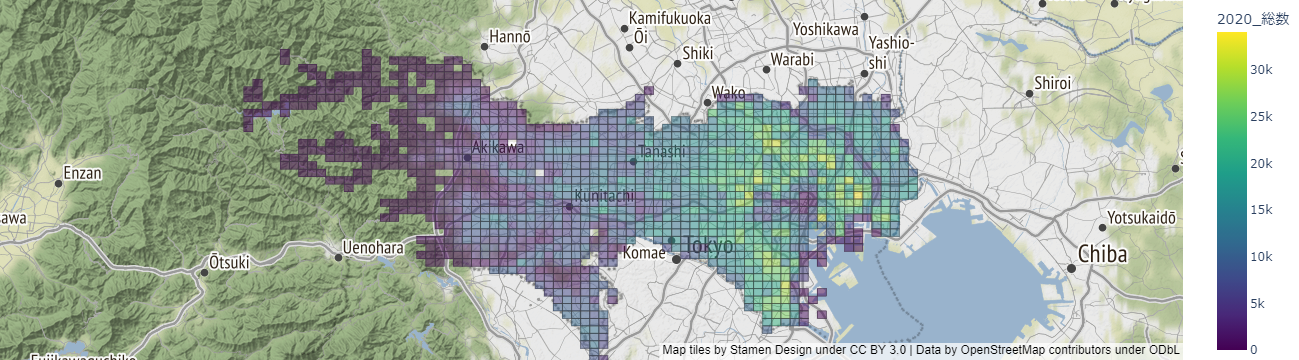

In [12]:
def myplot(df, geo):
    
    fig = px.choropleth_mapbox(
        df, 
        geojson=geo, 
        locations=df.index, 
        color='2020_総数',
        color_continuous_scale="Viridis",
        mapbox_style="stamen-terrain",
        zoom=9, center = { "lon": 139.464890, "lat": 35.704516 },
        opacity=0.5,
        labels={'unemp':'unemployment rate'}
    )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    
    
def plot_by_plotly(n):
    df = pd.read_json(f"{df_path}/{n:02}.json", orient="split", convert_axes =False).T
    
    with open(f"{geo_path}/{n:02}.json") as j:
        geo = json.load(j)
    
    myplot(df, geo)


plot_by_plotly(13)

## line

In [34]:
def get_total(n):
    path = f'{raw_path}/{n:02}.zip'
    gdf = gpd.read_file(path).set_index('MESH_ID')
    df = pd.DataFrame(gdf)
    total = ex_total(df, n)
    total.drop(columns=["pref"], inplace=True)
    total = total.melt(id_vars="group")
    total['year'] = pd.to_datetime(total.year)
    return total

In [35]:
def draw(df):
    fig = px.line(
        df.query('not group == "総数"'), 
        x="year", 
        y="value", 
        color="group", 
        markers=True,
        color_discrete_sequence=[c for i, c in enumerate(px.colors.sequential.Turbo_r) if not (i+1) % 3],
    )
    fig.update_traces(patch={
        'hovertemplate':'%{y:,d}人'
    })
    fig.update_layout(
        hovermode="x",
        updatemenus=(go.layout.Updatemenu(
            buttons=(
                go.layout.updatemenu.Button(
                    method='restyle',
                    args=['stackgroup', ''],
                    label='折れ線'
                ),
                go.layout.updatemenu.Button(
                    method='restyle',
                    args=['stackgroup', 'foo'],
                    label='積み上げ'
                )
            ),
            type='buttons'
        ),),
        legend=go.layout.Legend(
            traceorder='reversed'
        ),
        xaxis=go.layout.XAxis(
            tickformat='%Y',
            dtick='M60'
        ),
        yaxis=go.layout.YAxis(
            title='人口',
    #         ticksuffix='test'
            tickformat='s'
        )
    )
    return fig

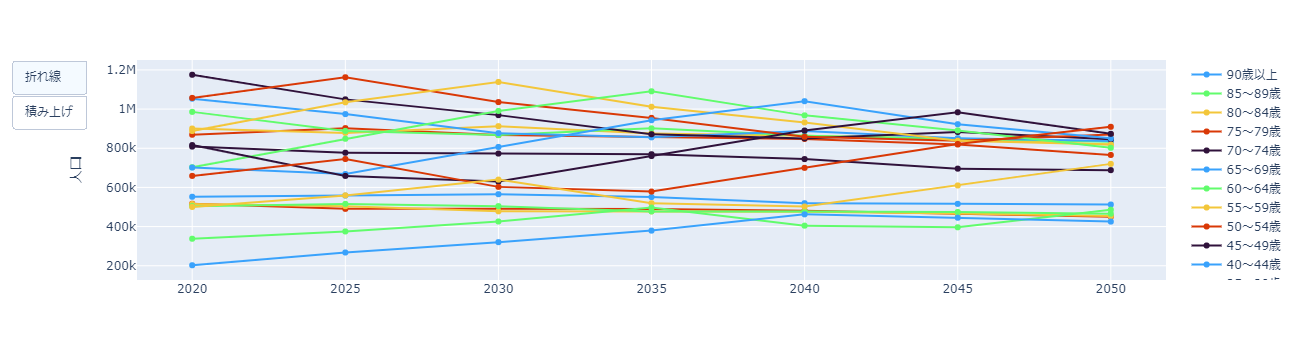

In [36]:
draw(get_total(13))